In [14]:
import pandas as pd
import numpy as np
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt

In [47]:
GBT_dir = '/home/fiona/birdMigration/results/radar/testing/GBT/best_settings/{"n_estimators": 50, "lr": 0.1, "max_depth": 7}'
results_GBT = pd.read_csv(osp.join(GBT_dir, 'results.csv'))

In [48]:
results_GBT.columns

Index(['Unnamed: 0', 'gt', 'prediction', 'night', 'radar', 'seqID', 'tidx',
       'datetime', 'trial'],
      dtype='object')

[None, None]

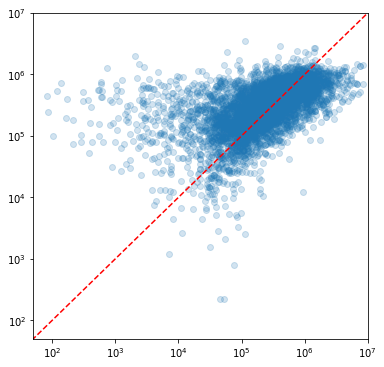

In [46]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(results_GBT['gt'].replace(0, np.nan).values, results_GBT['prediction'].replace(0, np.nan).values, alpha=0.2)
ax.plot([0,1e7], [0, 1e7], ls='--', c='red')
ax.set_xlim(50, 1e7)
ax.set_ylim(50, 1e7)
ax.set(yscale='symlog', xscale='symlog')

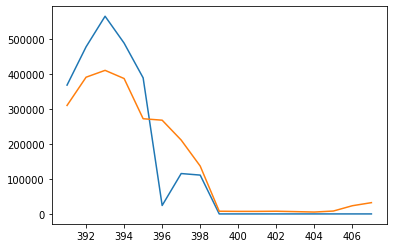

In [34]:
s1 = results_GBT.query('seqID == 1 & radar == "dehnr"')
plt.plot(s1['gt'])
plt.plot(s1['prediction'])

In [ ]:
results_GBT.groupby([''])